In [26]:
import os
import re
import json
import logging
import requests
import subprocess
import textstat
import bert_score
import pandas as pd
import seaborn as sns
from pathlib import Path
from rouge import Rouge
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu


from llm_parser import DeepSeekAPI
from io_functions import run, popen, load_if_scraped

In [27]:
logging.basicConfig(level=logging.INFO, force=True)

In [28]:
def get_ollama_version():
    try:
        result = subprocess.run(
            ['ollama', '--version'], 
            check=True, 
            stdout=subprocess.PIPE, 
            stderr=subprocess.PIPE, 
            text=True
        )
        return result.stdout.strip()
    except subprocess.CalledProcessError:
        return 'Error while checking Ollama version.'

get_ollama_version()

'ollama version is 0.5.13'

In [22]:
ollama_server_process = popen('ollama serve')

ollama_server_process

<Popen: returncode: None args: ['ollama', 'serve']>

In [23]:
process = run('ollama list')

process

CompletedProcess(args=['ollama', 'list'], returncode=0, stdout='NAME              ID              SIZE      MODIFIED    \ndeepseek-r1:8b    28f8fd6cdc67    4.9 GB    3 hours ago    \n', stderr='')

In [24]:
models = [
    line.strip() for line in process.stdout.split('\n') 
        if (line.strip() != '' and 
            line.strip() != 'NAME              ID              SIZE      MODIFIED')
]

model_list = [model.split()[0] for model in models]
model_list

['deepseek-r1:8b']

To prevent running a non-existing model:

In [7]:
model_name = model_list[0]
model_name

'deepseek-r1:8b'

In [41]:
print(run(f'ollama show {model_name}').stdout)

  Model
    architecture        llama     
    parameters          8.0B      
    context length      131072    
    embedding length    4096      
    quantization        Q4_K_M    

  Parameters
    stop    "<｜begin▁of▁sentence｜>"    
    stop    "<｜end▁of▁sentence｜>"      
    stop    "<｜User｜>"                 
    stop    "<｜Assistant｜>"            

  License
    MIT License                    
    Copyright (c) 2023 DeepSeek    




In [42]:
def extract_model_info(text: str):
    embedding_match = re.search(r'embedding length\s+(\d+)', text)
    context_match = re.search(r'context length\s+(\d+)', text)
    
    embedding_length = int(embedding_match.group(1)) if embedding_match else None
    context_length = int(context_match.group(1)) if context_match else None
    
    return {
        'embedding_length': embedding_length,
        'context_length': context_length
    }

model_info = extract_model_info(run(f'ollama show {model_name}').stdout)
model_info

{'embedding_length': 4096, 'context_length': 131072}

In [8]:
if model_name not in model_list:
    run(f'ollama pull {model_name}')

In [9]:
model_process = popen(f'ollama run {model_name}')

In [10]:
company_id = '312932093'

In [11]:
df = load_if_scraped(company_id=company_id)

df.head()

INFO:root:successfully loaded local transcripts


,companyid,companyname,mostimportantdateutc,mostimportanttimeutc,headline,full_text,uuid,word_count,word_count_nltk
0,312932093,Google LLC,2018-05-10,15:30:00,Google LLC Presents at The 14th annual Red Hat...,Attendees: Now if there's a company that under...,123c9e75-b8dc-40b1-b21c-ffc9e71e01c6,12407,14475
1,312932093,Google LLC,2023-06-15,21:00:00,"Google LLC, Squarespace, Inc. - M&A Call","Operator: Good afternoon. My name is Sara, and...",123c9e75-b8dc-40b1-b21c-ffc9e71e01c6,10078,11800


In [12]:
deepseek = DeepSeekAPI(
    model=model_name
)

In [13]:
summaries = []
for text in tqdm(df.full_text):
    prompt = 'summarize: ' + text
    summary = deepseek.generate(prompt)
    summaries.append(summary)

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:root:Response received from model deepseek-r1:8b
INFO:root:Response received from model deepseek-r1:8b


In [14]:
summary_column = f'{model_name}-summaries'
df[summary_column] = summaries

In [15]:
def evaluate_summary(row, model_name, type = 'baseline'):
    text_to_summarize = row.full_text
    summary = row[summary_column]
    uuid = row.uuid
    company_id = row.companyid
    company_name = row.companyname

    rouge_evaluator = Rouge()
    rouge_scores = rouge_evaluator.get_scores(summary, text_to_summarize)
    
    if isinstance(rouge_scores, list):
        rouge_scores = rouge_scores[0]
    
    reference_tokens = text_to_summarize.split()
    candidate_tokens = summary.split()
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens)
    
    P, R, F1 = bert_score.score(
        [summary], 
        [text_to_summarize], 
        rescale_with_baseline=True, 
        lang='en'
    )
    
    original_len = len(text_to_summarize.split())
    summary_len = len(summary.split())
    compression_ratio = summary_len / original_len if original_len > 0 else 0
    
    readability = textstat.flesch_reading_ease(summary)
    
    results = {}
    results['model_name'] = model_name
    results['uuid'] = uuid
    results['companyid'] = company_id
    results['companyname'] = company_name

    for metric, scores in rouge_scores.items():
        results[f'{metric}_r'] = scores['r']
        results[f'{metric}_p'] = scores['p']
        results[f'{metric}_f'] = scores['f']
    
    results['bleu'] = bleu_score
    results['bert_precision'] = P.item()
    results['bert_recall'] = R.item()
    results['bert_f1'] = F1.item()
    results['compression_ratio'] = compression_ratio
    results['readability'] = readability
    
    return pd.DataFrame([results])

In [29]:
evaluation_results = pd.DataFrame()

for index, row in tqdm(df.iterrows()):
    evaluation_result = evaluate_summary(row, model_name)
    evaluation_results = pd.concat([evaluation_results, evaluation_result], ignore_index=True)

evaluation_results.head()

0it [00:00, ?it/s]

/workspace/persistent/ragsum/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/workspace/persistent/ragsum/venv/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.war

,model_name,uuid,companyid,companyname,rouge-1_r,rouge-1_p,rouge-1_f,rouge-2_r,rouge-2_p,rouge-2_f,rouge-l_r,rouge-l_p,rouge-l_f,bleu,bert_precision,bert_recall,bert_f1,compression_ratio,readability
0,deepseek-r1:8b,123c9e75-b8dc-40b1-b21c-ffc9e71e01c6,312932093,Google LLC,0.067404,0.446667,0.117133,0.007620,0.105528,0.014213,0.063380,0.420000,0.110140,6.763638e-104,-0.18643,-0.292449,-0.238026,0.016765,18.45
1,deepseek-r1:8b,123c9e75-b8dc-40b1-b21c-ffc9e71e01c6,312932093,Google LLC,0.064979,0.550000,0.116226,0.004542,0.088542,0.008640,0.060759,0.514286,0.108679,3.490334e-100,-0.13982,-0.387202,-0.264735,0.019647,12.43


In [30]:
csv_filename = Path('..') / 'data' / 'evaluation_results.csv'

if os.path.exists(csv_filename):
    existing_df = pd.read_csv(csv_filename)
    if ((existing_df.model_name == model_name) & (existing_df.companyid == company_id)).any():
        logging.info(f'model {model_name} and {company_id} combination already exists in {csv_filename}. no new row added.')
        updated_df = existing_df
    else:
        updated_df = pd.concat([existing_df, evaluation_results], ignore_index=True)
        logging.info(f'model {model_name} not found. appending new row to {csv_filename}.')
else:
    updated_df = evaluation_results
    logging.info(f'{csv_filename} not found. creating new file.')

updated_df.to_csv(csv_filename, index=False)
logging.info(f'results saved to {csv_filename}')

INFO:root:model deepseek-r1:8b not found. appending new row to ../data/evaluation_results.csv.
INFO:root:results saved to ../data/evaluation_results.csv


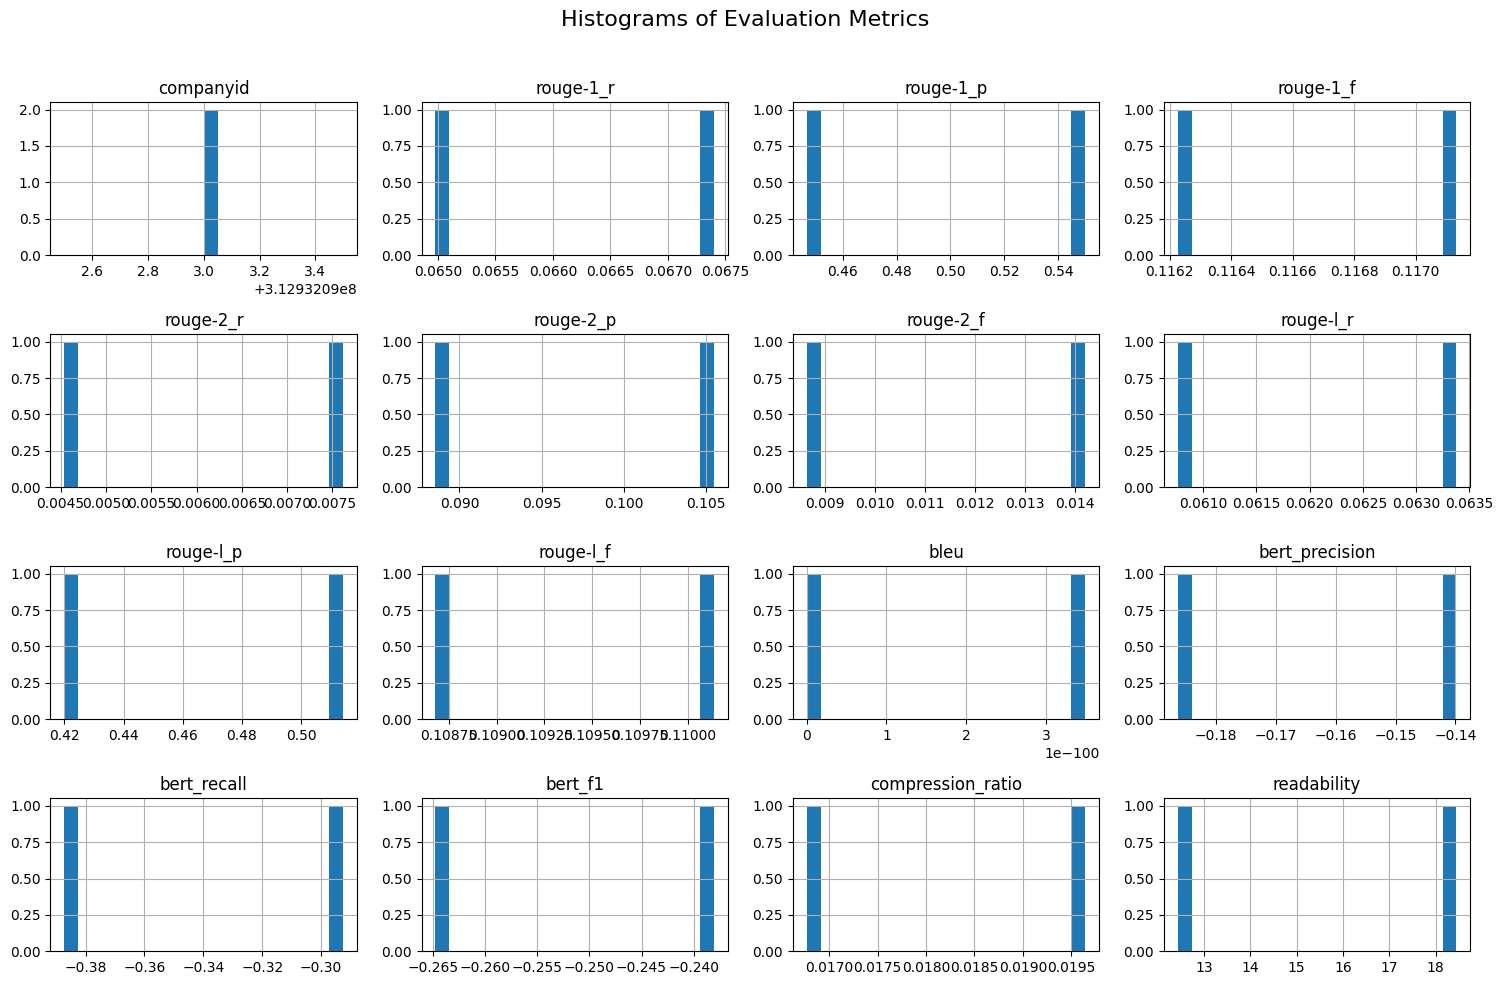

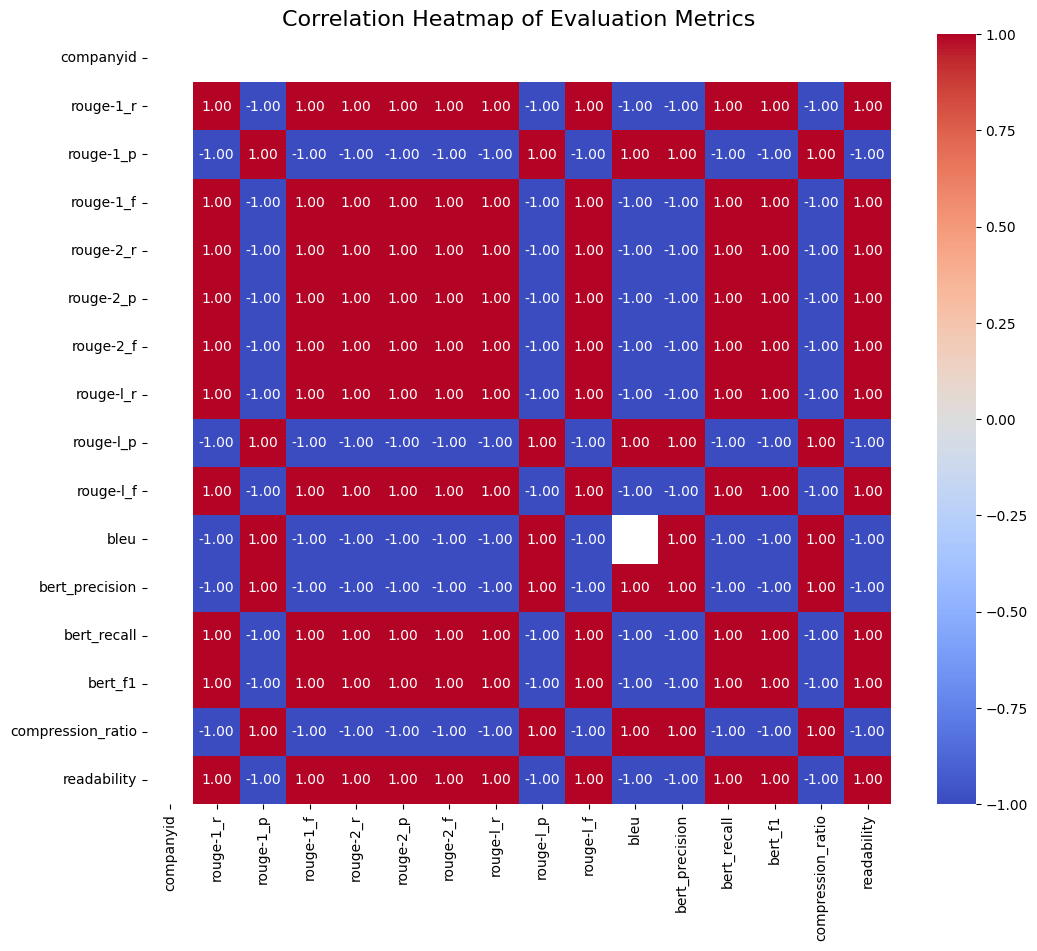

In [31]:
def visualize_results(df):
    '''
    Visualizes evaluation metrics stored in a DataFrame.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing evaluation results with numeric metric columns.
    
    This function produces:
    - Histograms for each numeric metric.
    - A correlation heatmap of the numeric metrics.
    '''
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    
    df[numeric_cols].hist(bins=20, figsize=(15, 10))
    plt.suptitle('Histograms of Evaluation Metrics', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Evaluation Metrics', fontsize=16)
    plt.show()

visualize_results(evaluation_results)

In [32]:
df.to_csv(
        Path('..') / 'data' / 'summaries' / f'{company_id}_{model_name}.csv'.replace('/','-'),
        sep='\t',
        index=False,
        quoting=1,
        escapechar='\\',
        doublequote=True,
        quotechar='"',
        lineterminator='\n'
    )

In [38]:
print(df.full_text[0])

Attendees: Now if there's a company that understands these changes, including machine learning and big data, as well as open source and collaboration, it's Google. You saw one of Google's open source projects, TensorFlow, in today's demo. Just a few minutes, Google Chief Decision Scientist will be here. But before she gives you more information about what intelligent apps will really look like, we'll hear from a shared customer, Kohl's, about their journey with Red Hat and Google. So please welcome Ritch from Kohl's and Cassie from Google.
Attendees: All right. Most of you know Kohl's as a chain of leading American department stores, but you might not know that there's also been a long-time customer of Red Hat. Ritch, could you tell a little bit about Kohl's and your relationship with us?
Attendees: Sure thing. So first of all, it's great to be here. I was really looking forward to summit this year, and then I saw Weezer was playing, and that put me right over the top, icing on the cak

In [33]:
df[summary_column][0]

"The analogy of machine learning as a kitchen highlights its versatility and accessibility, much like how a kitchen offers various tools for cooking. Here's the breakdown:\n\n1. **Accessibility**: Just as you don't need to build your own microwave, you don't need a degree to use machine learning. The tools are ready to use, democratizing access.\n\n2. **Prepared Tools**: The necessary algorithms and platforms (like Google Cloud) are already available, allowing for immediate application without technical expertise, such as creating an automatic vegetable sorter.\n\n3. **Open Source and Flexibility**: The open-source nature of these tools means they can be customized and modified, providing flexibility. This allows businesses to adapt as needs change, avoiding the constraints of proprietary systems.\n\n4. **Use Cases**: Real-world applications like fraud detection in banking illustrate the practicality and impact of machine learning, making it relatable beyond abstract concepts.\n\n5. **

In [35]:
model_process.terminate()
ollama_server_process.terminate()